## Kafka AdTech dataset EDA

The goal of this project is to collect the adtech data from kafka platform. This platform allows to create a pipeline to extract the data once at the specific period of time, so what I have extracted the 7 million rows of adtech data to provide the EDA on it.

Guide how to extract the data from this platform using SingleStore database is available [here](https://docs.singlestore.com/cloud/developer-resources/functional-extensions/load-and-analyze-adtech-data/).

### Importing the neccessary libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Spectral')

In [2]:
data = pd.read_csv('output.csv')

### Defining the plotting functions

In [76]:
def plot_cat_counts(data, cat_cols, shape=(2, 2), figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        ax.ticklabel_format(style='plain', useOffset=False)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
        )

        ax_ = sns.barplot(data[cat_cols[i]].value_counts(), ax=ax)
        max_height = ax.get_ylim()[1]

        for p in ax_.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height+max_height*.01, "{:,}".format(int(height)),
                    ha="center")

        ax.set_title(f'\'{cat_cols[i]}\' distribution')
        ax.tick_params(axis='y', rotation=45)
        ax.tick_params(axis='x', rotation=25)
    plt.show()

def plot_num_dists(data, num_cols, shape=(2, 2), figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        sns.histplot(data[num_cols[i]], bins=80, kde=True, ax=ax)
        ax.set_title(f'\'{num_cols[i]}\' distribution')
        ax.text(0.80, 0.95,
                f"skew={round(data[num_cols[i]].skew(), 2)}\n"+
                f"kurtosis={round(data[num_cols[i]].kurtosis(), 2)}",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
    plt.show()

def plot_top_counts(data, cat_col, top_k=10, figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.ticklabel_format(style='plain', useOffset=False)
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax_ = sns.barplot(data[cat_col].value_counts()[:top_k], ax=ax)
    max_height = ax.get_ylim()[1]

    for p in ax_.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height+max_height*.01, "{:,}".format(int(height)),
                ha="center")

    ax.set_title(f'Top {top_k} values for {cat_col}')
    ax.tick_params(axis='y', rotation=45)
    ax.tick_params(axis='x', rotation=25)
    plt.show()

def cat_to_q_plot(data, cat_col, num_cols, hist_bins=80, shape=(2, 4), figsize=(15, 8)):
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(*shape, figure=fig)

    col_idx = 0
    for row in range(shape[0]):
        for col in range(0, shape[1], 2):
            ax1 = plt.subplot(grid[row, col])
            ax2 = plt.subplot(grid[row, col+1])

            sns.histplot(data=data.sample(1000), x=num_cols[col_idx], hue=cat_col, ax=ax1, bins=hist_bins)
            sns.boxplot(data=data.sample(1000), x=num_cols[col_idx], hue=cat_col, ax=ax2)

            col_idx += 1
    plt.show()

def cat_to_cat_plot(data, target, cat_cols, normalize=False, order_index=False, order_column=False, shape=(2, 2), figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        if not normalize:
            ax.ticklabel_format(style='plain', useOffset=False)
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            ax.tick_params(axis='y', rotation=45)
        cross = pd.crosstab(index=data[target], columns=data[cat_cols[i]], normalize=normalize)
        cross.loc[cross.index if not order_index else order_index, cross.columns if not order_column else order_column].plot(kind='bar', ax=ax)
    plt.show()

### Basic data overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 9 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     int64 
 1   event_name  object
 2   advertiser  object
 3   campaign    int64 
 4   gender      object
 5   income      object
 6   page_url    object
 7   region      object
 8   country     object
dtypes: int64(2), object(7)
memory usage: 549.3+ MB


In [5]:
data.head()

,user_id,event_name,advertiser,campaign,gender,income,page_url,region,country
0,2147483647,Click,7-Eleven,1,Female,25k and below,/2016/04/diy-paper-spring-floral-crown.html/2/,undefined,FR
1,2147483647,Click,7-Eleven,1,Female,unknown,/2014/11/gold-leaf-planters.html/,Ontario,CA
2,2147483647,Click,7-Eleven,1,Male,25k and below,/2014/06/brazilian-coconut-bars.html/,New York,US
3,2147483647,Click,7-Eleven,1,Female,unknown,/2016/05/day-2-of-the-lars-flower-drawing-chal...,Victoria,AU
4,2147483647,Click,7-Eleven,1,Female,50k - 75k,NaN,California,US


In [6]:
data.tail()

,user_id,event_name,advertiser,campaign,gender,income,page_url,region,country
7999995,2147483647,Impression,YUM! Brands,13,Female,50k - 75k,/2014/04/5-minute-bookbinding.html/4/,California,US
7999996,2147483647,Impression,YUM! Brands,13,Male,25k - 50k,/,undefined,undefined
7999997,2147483647,Impression,YUM! Brands,13,Female,75k - 99k,/2014/07/balloon-arch-tutorial.html/8/,Virginia,US
7999998,2147483647,Impression,YUM! Brands,13,Female,75k - 99k,/2016/04/diy-paper-spring-floral-crown.html/,Virginia,US
7999999,2147483647,Impression,YUM! Brands,13,Female,75k - 99k,/2013/04/weekend-project-fruit-welcome-mats.html/,Virginia,US


The dataset only consists of categorical variables, here is some explanation about each particular feature (data dictionary)

- __user_id__:    unique number of a user that click/see the advertising (object)
- __event_name__: the action that user took on a website (click/impression etc.) (object)
- __advertiser__: company that provides the add (object)
- __campaign__:   the name of an ad campaign (object)
- __gender__:     the sex of a user (object)
- __income__:     the user's salary/income (object)
- __page_url__:   the url on which the ad was shown (object)
- __region__:     city or state (object)
- __country__:    where the event was made (object)

We can immediately get rid of unnecessary values

In [7]:
data.drop(['user_id', 'page_url'], axis=1, inplace=True)

#### Missing values analysis

In [8]:
data.shape

(8000000, 7)

We have 8M rows of data to analyze

In [9]:
data.isna().sum()

event_name    0
advertiser    0
campaign      0
gender        0
income        0
region        0
country       0
dtype: int64

In [10]:
print(f"{len(data[data['income'] == 'unknown'])/len(data)*100:.2f}% missing data for income")

35.48% missing data for income


In [11]:
print(f"{len(data[data['region'] == 'undefined'])/len(data)*100:.2f}% missing data for region")

8.45% missing data for region


In [12]:
print(f"{len(data[data['country'] == 'undefined'])/len(data)*100:.2f}% missing data for country")

0.36% missing data for country


In [13]:
print(f"{len(data[data['gender'] == 'unknown'])/len(data)*100:.2f}% missing data for country")

22.72% missing data for country


#### Imputation strategy for missing data:
- We do not have any missing data for user_id, event_name, advertiser and campaign columns.
- The "country" feature has only 0.36% of missing values, so we can just use the mode to impute them all.

In [14]:
data[data['country'] == 'undefined']

,event_name,advertiser,campaign,gender,income,region,country
18,Click,7-Eleven,1,unknown,50k - 75k,undefined,undefined
276,Click,7-Eleven,1,unknown,unknown,undefined,undefined
318,Click,7-Eleven,1,Male,unknown,undefined,undefined
763,Click,7-Eleven,1,unknown,50k - 75k,undefined,undefined
1443,Click,7-Eleven,2,Male,25k - 50k,undefined,undefined
...,...,...,...,...,...,...,...
7999735,Impression,YUM! Brands,13,unknown,75k - 99k,undefined,undefined
7999823,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined
7999837,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined
7999880,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined


In [15]:
data[data['region'] == 'undefined']

,event_name,advertiser,campaign,gender,income,region,country
0,Click,7-Eleven,1,Female,25k and below,undefined,FR
18,Click,7-Eleven,1,unknown,50k - 75k,undefined,undefined
19,Click,7-Eleven,1,Female,unknown,undefined,GB
21,Click,7-Eleven,1,Female,50k - 75k,undefined,CH
30,Click,7-Eleven,1,Male,unknown,undefined,ES
...,...,...,...,...,...,...,...
7999915,Impression,YUM! Brands,13,Female,unknown,undefined,PH
7999918,Impression,YUM! Brands,13,Female,unknown,undefined,PH
7999919,Impression,YUM! Brands,13,unknown,unknown,undefined,TW
7999971,Impression,YUM! Brands,13,Male,25k - 50k,undefined,SI


In [16]:
data[(data['country'] == 'undefined') & (data['region'] == 'undefined')]

,event_name,advertiser,campaign,gender,income,region,country
18,Click,7-Eleven,1,unknown,50k - 75k,undefined,undefined
276,Click,7-Eleven,1,unknown,unknown,undefined,undefined
318,Click,7-Eleven,1,Male,unknown,undefined,undefined
763,Click,7-Eleven,1,unknown,50k - 75k,undefined,undefined
1443,Click,7-Eleven,2,Male,25k - 50k,undefined,undefined
...,...,...,...,...,...,...,...
7999735,Impression,YUM! Brands,13,unknown,75k - 99k,undefined,undefined
7999823,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined
7999837,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined
7999880,Impression,YUM! Brands,13,Female,25k and below,undefined,undefined


We can see, that for every missing country we also miss the region, which makes sense, so after imputing the coutry with the most frequent value we can impute the region with respect to that country.

In [17]:
data.country.mode().values[0]

'US'

In [18]:
data.loc[data['country'] == 'undefined', 'country'] = data.country.mode().values[0]

In [19]:
top_region_by_country = data.groupby('country')['region'].agg(pd.Series.mode)
top_region_by_country = pd.DataFrame({'country': top_region_by_country.index, 'region': top_region_by_country.values})

In [20]:
len(top_region_by_country[top_region_by_country.region == 'undefined'])

54

In [21]:
len(top_region_by_country[top_region_by_country.region != 'undefined'])

35

There are still 54 coutries for which the most frequent region is undefined, but for now we can at least input those ones for which it is defined

In [22]:
data.loc[data.region == 'undefined', 'region'] = data.loc[data.region == 'undefined', 'country'].map({country: region for country, region in zip(top_region_by_country.country, top_region_by_country.region)})

In [23]:
print(f"{len(data[data['region'] == 'undefined'])/len(data)*100:.2f}% missing data for region")

1.44% missing data for region


We have reduced the number of missing regions by 7% but there are still some missing regions, I think now we can drop them because those regions are from uncommon countries and cann't be replaced with anything

In [24]:
data = data[data.region != 'undefined']

Now, we still have the income and gender which have 35.48% and 25.72% of missing data respectively. I think first of all we can drop the samples where both income and gender are missing and then proceed with the rest data

In [25]:
data.loc[data['gender'] == 'unknown', 'gender'] = None
data.loc[data['income'] == 'unknown', 'income'] = None

In [26]:
data[data.gender.isna() & data.income.isna()]

,event_name,advertiser,campaign,gender,income,region,country
40,Click,7-Eleven,1,None,None,Massachusetts,US
67,Click,7-Eleven,1,None,None,British Columbia,CA
79,Click,7-Eleven,1,None,None,California,US
82,Click,7-Eleven,1,None,None,Utah,US
112,Click,7-Eleven,1,None,None,Oklahoma,US
...,...,...,...,...,...,...,...
7999925,Impression,YUM! Brands,13,None,None,Arizona,US
7999958,Impression,YUM! Brands,13,None,None,California,US
7999969,Impression,YUM! Brands,13,None,None,Idaho,US
7999970,Impression,YUM! Brands,13,None,None,Idaho,US


There are almost a 650,000 missing values for both income and gender and it won't be a good idea to just drop.
So I will impute 'gender' variable with respect to the advertiser, because some brands can be more interesting for woman and some for man.

In [27]:
top_gender_by_advertiser = data.groupby('advertiser')['gender'].agg(pd.Series.mode).to_frame().reset_index(drop=False)
top_gender_by_advertiser

,advertiser,gender
0,7-Eleven,Male
1,A&P,Male
2,AT&T Wireless,Male
3,AVB Brandsource,Male
4,Ace Hardware,Male
...,...,...
92,Wendys,Male
93,Whole Foods Market,Male
94,Williams-Sonoma,Male
95,WinCo Foods,Male


In [28]:
data.loc[data.gender.isna(), 'gender'] = data.loc[data.gender.isna(), 'advertiser'].map({advertiser: gender for advertiser, gender in zip(top_gender_by_advertiser.advertiser, top_gender_by_advertiser.gender)})

And now, with the last income column we can follow this strategy and impute the missing data with the most frequent value for income with respect to the gender

In [29]:
top_income_by_gender = data.groupby(['region', 'gender'])['income'].agg(pd.Series.mode).to_frame().reset_index(drop=False)
top_income_by_gender.income.unique()

array(['50k - 75k'], dtype=object)

As we can see, every grouping gives us the most common value of 50k-75k which makes sense because it's the average salary. So we can use this value for imputation.

In [30]:
data.loc[data.income.isna(), 'income'] = '50k - 75k'

In [31]:
data.isna().sum()

event_name    0
advertiser    0
campaign      0
gender        0
income        0
region        0
country       0
dtype: int64

And now we're done with missing data.

#### Let's also do some basic preprocessing for the data to be more suitable to provide EDA on.

In [32]:
data.campaign = data.campaign.map({
    1: 'demand great',
    2: 'blackout',
    3: 'flame broiled',
    4: 'take it form a fish',
    5: 'thank you',
    6: 'designed by you',
    7: 'virtual launch',
    8: 'ultra light',
    9: 'warmth',
    10: 'run healthy',
    11: 'virtual city',
    12: 'online lifestyle',
    13: 'dream burger',
    14: 'super bowl tweet',
})

data.event_name = data.event_name.map({
    'Downstream Conversion': 'convertion',
    'Click': 'click',
    'Impression': 'impression'
})

### EDA (Exploratory data analysis)

In [33]:
data.describe()

,event_name,advertiser,campaign,gender,income,region,country
count,7884646,7884646,7884646,7884646,7884646,7884646,7884646
unique,3,97,13,2,5,99,35
top,impression,Subway,dream burger,Male,50k - 75k,California,US
freq,6886329,746718,1899805,5486309,4498484,1186773,5445195


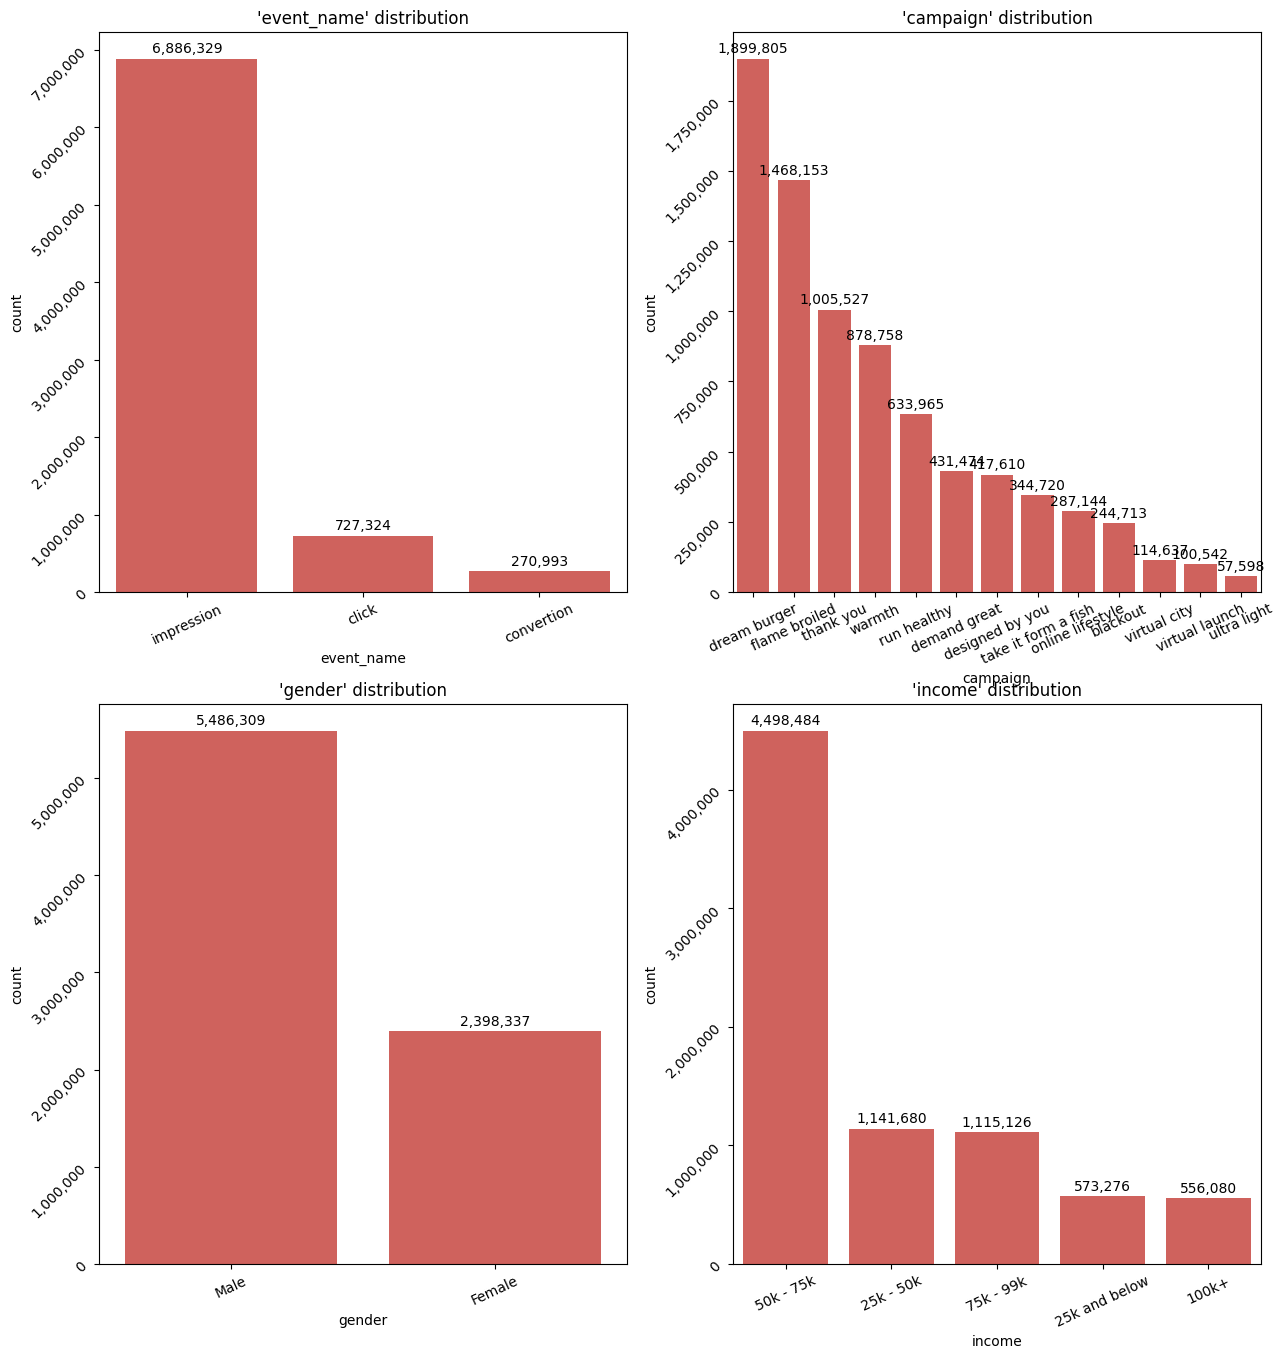

In [34]:
plot_cat_counts(data, ['event_name', 'campaign', 'gender', 'income'], figsize=(15, 16))

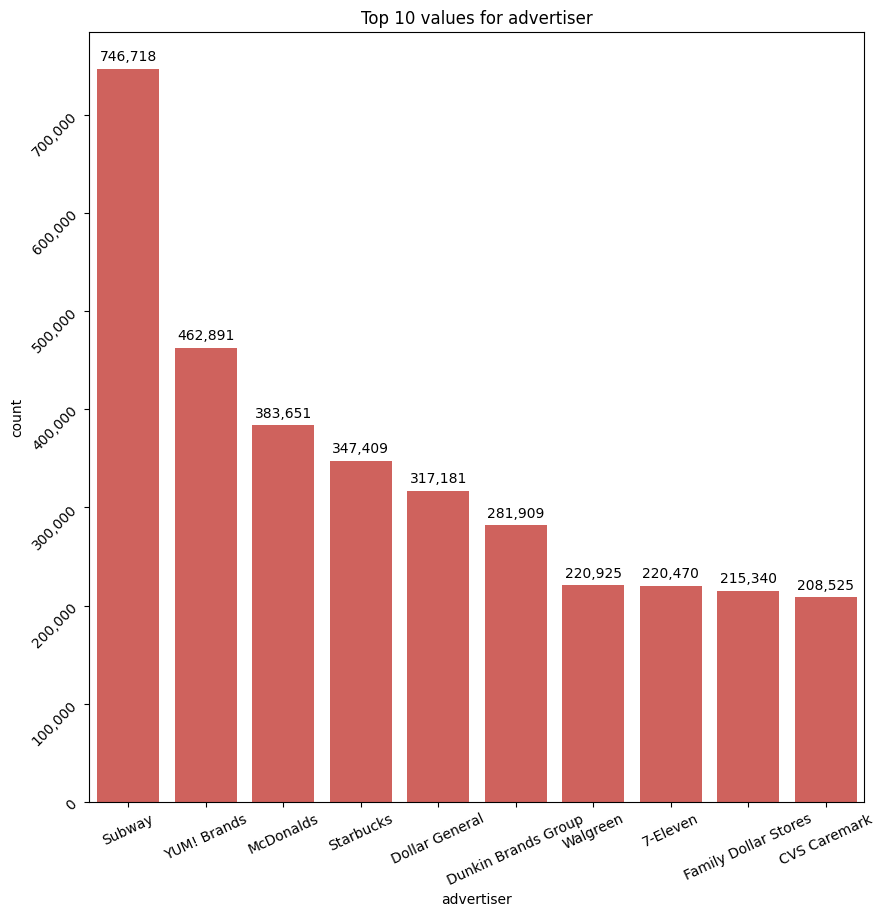

In [35]:
plot_top_counts(data, 'advertiser', top_k=10)

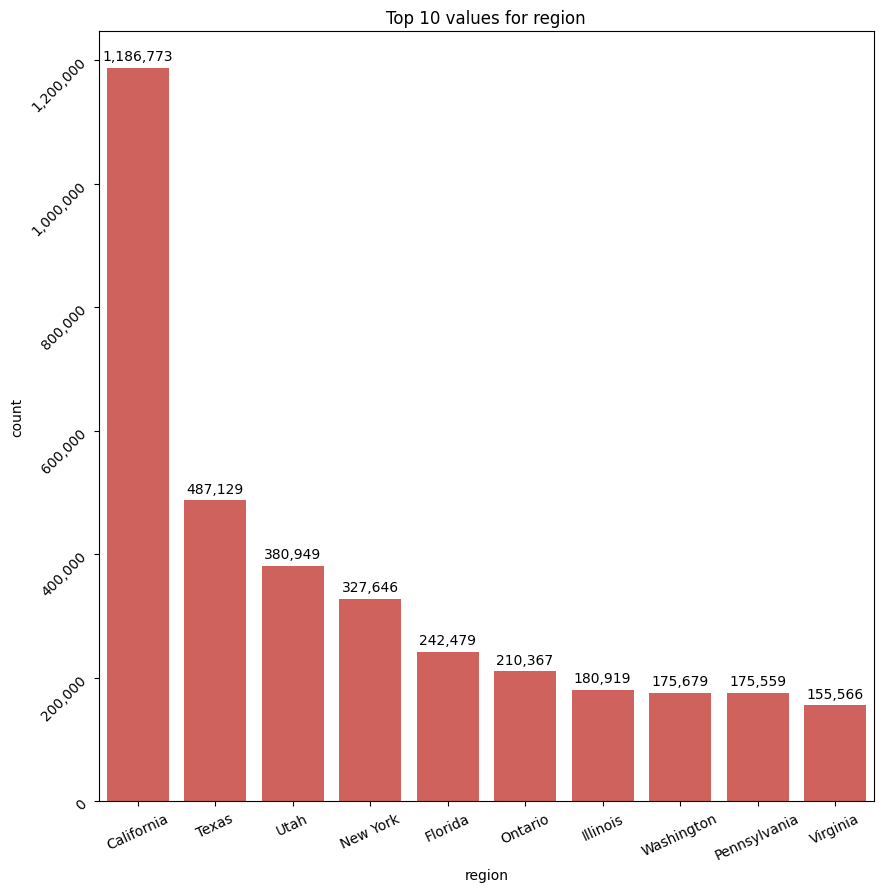

In [36]:
plot_top_counts(data, 'region', top_k=10)

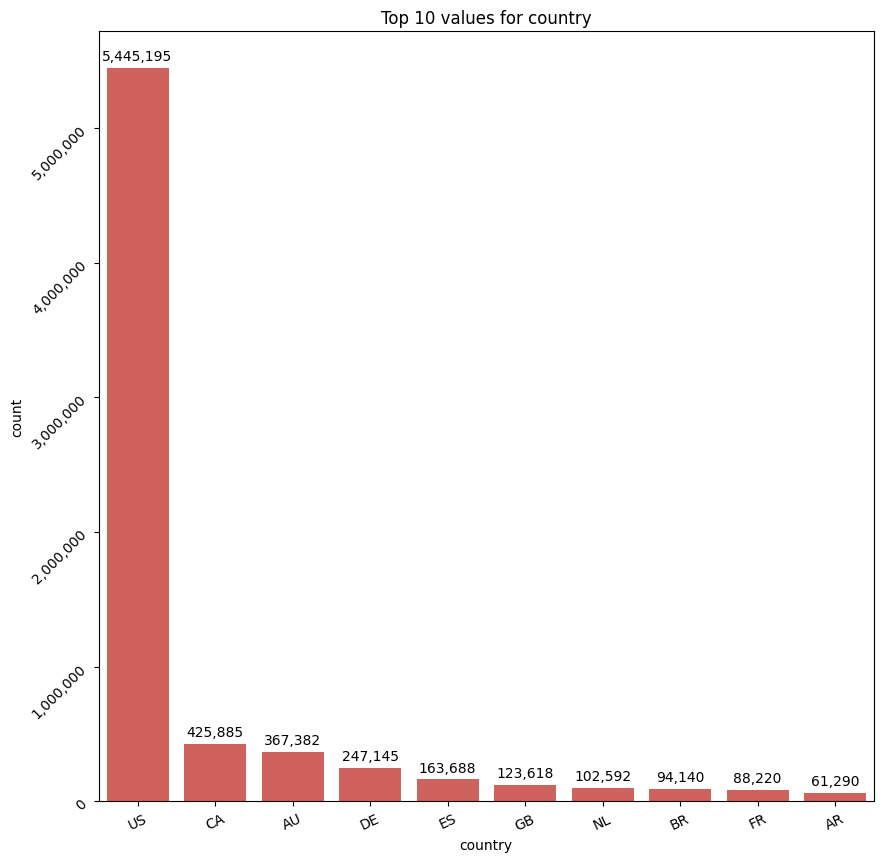

In [37]:
plot_top_counts(data, 'country', top_k=10)

#### Let's explore some relationships of categorical variables between each other

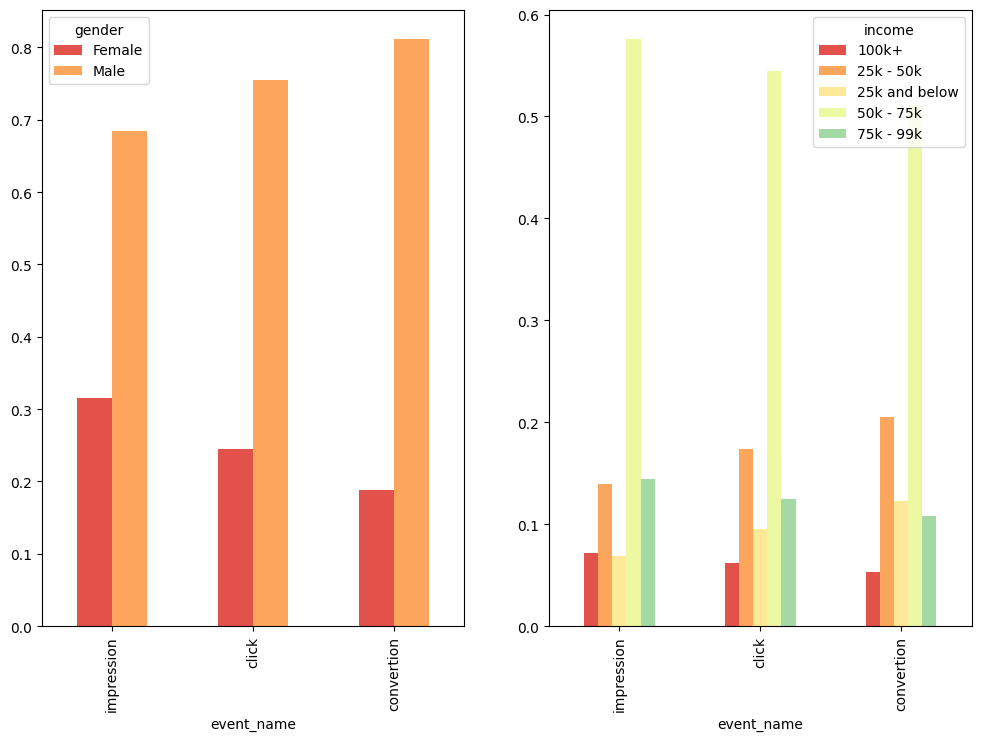

In [38]:
cat_to_cat_plot(
    data, 
    target='event_name', 
    cat_cols=['gender', 'income'], 
    normalize='index', 
    order_index=['impression', 'click', 'convertion'],
    shape=(1, 2), 
    figsize=(12, 8)
)

From these plots we can have the following conclusions:
1. The further we go with the client engagement the more male and less female persons we get.
2. With each additional engagement step we have more people with the median salary (50k and below) and less people with the higher salary started from 50k.

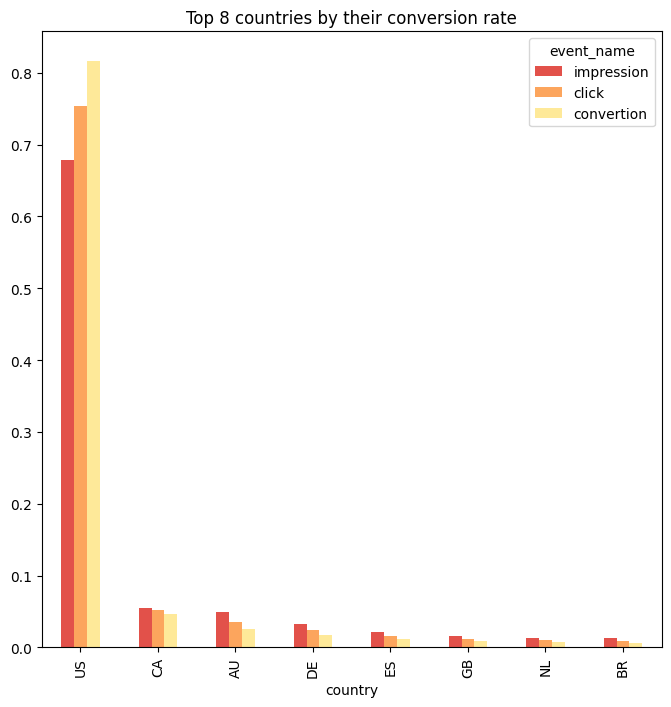

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Top 8 countries by their conversion rate')
pd.crosstab(index=data['country'], columns=data['event_name'], normalize='columns').loc[:, ['impression', 'click', 'convertion']].sort_values(by='convertion', ascending=False).head(8).plot(kind='bar', ax=ax)
plt.show()

Conclusions:
1. USA has the biggest part of all of the events, the next is CA but it's more closer to the others

As the USA has the biggest part of all events from all of the other countries we should devide this variable by it's regions to have a better view

In [40]:
data.region = data.country.astype(str) + '_' + data.region.astype(str)

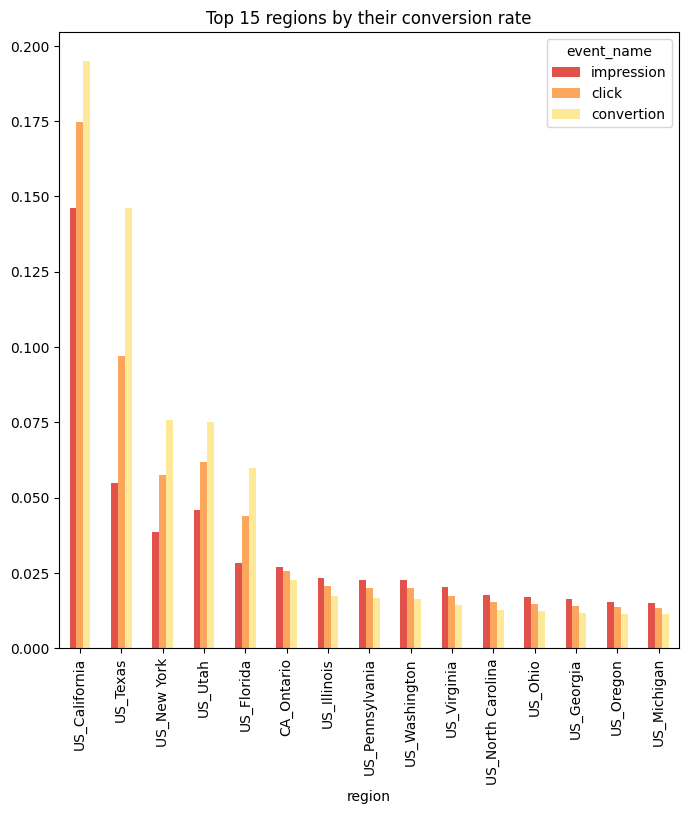

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Top 15 regions by their conversion rate')
pd.crosstab(index=data['region'], columns=data['event_name'], normalize='columns').loc[:, ['impression', 'click', 'convertion']].sort_values(by='convertion', ascending=False).head(15).plot(kind='bar', ax=ax)
plt.show()

Conclusions:
1. We can see, that basically the biggest part of engagements came from US, namely from California, Texas, New York and so on. Also we can see, that Canadian province Ontario is also in this list.
2. Within the states themselves we can observe the Texas has a high click and convertion rates even though the amount of impressions is significantly lower than in the California.

#### Checking the income of engaged people per each campaign

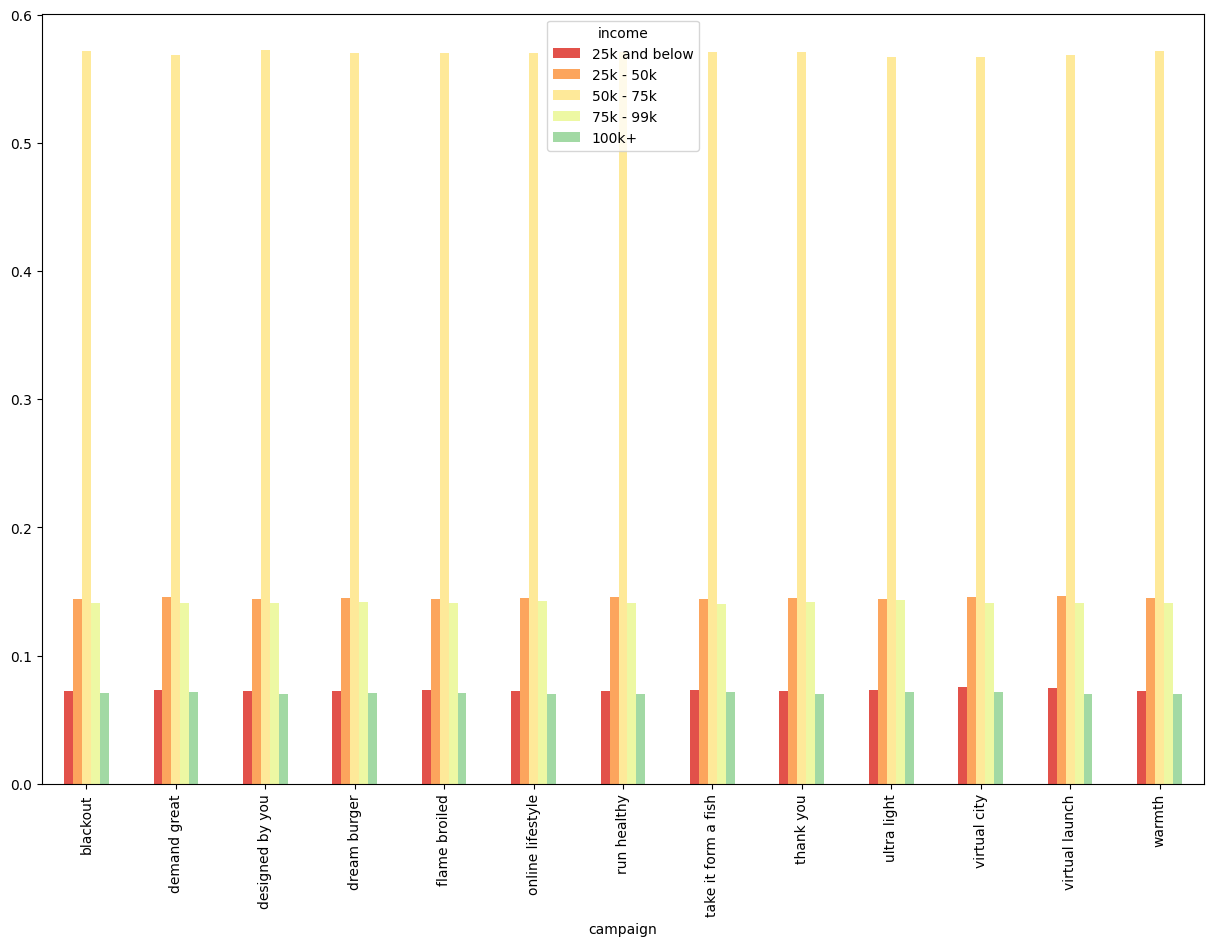

In [42]:
cat_to_cat_plot(
    data,
    target='campaign',
    cat_cols=['income'],
    normalize='index',
    order_column=['25k and below', '25k - 50k', '50k - 75k', '75k - 99k', '100k+'],
    shape=(1, 1),
    figsize=(15, 10)
)

Conclusions:
1. We can see, that for each advertising campaign we have the same distribution for people's salaries

But let's also see engagements

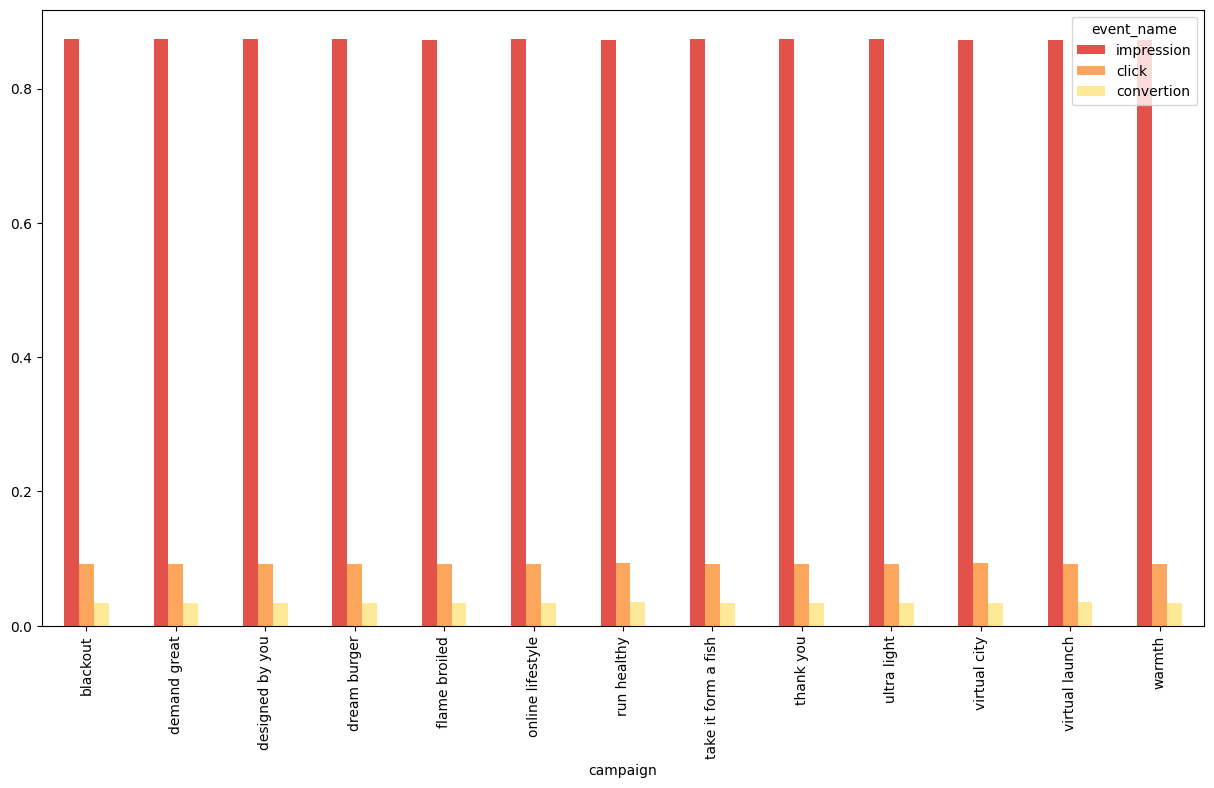

In [43]:
cat_to_cat_plot(
    data=data,
    target='campaign',
    cat_cols=['event_name'],
    normalize='index',
    order_column=['impression', 'click', 'convertion'],
    shape=(1, 1),
    figsize=(15, 8)
)

Conclusions:
1. The same goes for engagements - people don't want to click more on any of the ad campaigns here.

#### Providing the Chi2 test to see the relationship of other features with the engagement

In [44]:
X, y = data.loc[:, 'advertiser':], data.event_name

Encoding the features because for Chi2 test we need to have the non-zero numbers

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

le = LabelEncoder()
X = X.apply(le.fit_transform)

In [46]:
chi2_stat, p_values = chi2(X, y)

# Results
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Stat': chi2_stat,
    'P-value': p_values
})

In [47]:
chi2_results.style.map(lambda x: 'background-color : green' if x < 0.05 else '', subset=['P-value'])

,Feature,Chi2 Stat,P-value
0,advertiser,162620.582702,0.000000
1,campaign,2.870951,0.238002
2,gender,9923.594244,0.000000
3,income,4370.132076,0.000000
4,region,416296.918091,0.000000
5,country,145065.879935,0.000000


We can see, that basically all the features except campaign have some significant relationship to the target and can be used to predict it.

#### Let's calculate CTR per each advertiser to see how other features can affect CTR.

In [57]:
clicks = data[data.event_name == 'click'].groupby('advertiser').size().reset_index(name='clicks')
impressions = data[data.event_name == 'impression'].groupby('advertiser').size().reset_index(name='impressions')

In [65]:
ctr = pd.merge(left=clicks, right=impressions, on='advertiser').assign(CTR=lambda x: x['clicks'] / x['impressions'])

In [69]:
data = pd.merge(right=data, left=ctr[['advertiser', 'CTR']], on='advertiser')

First we will check the distribution of this new variable

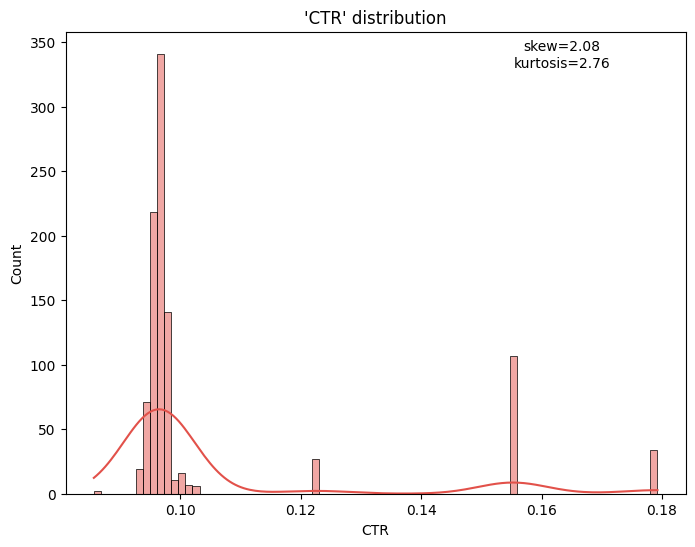

In [74]:
plot_num_dists(
    data=data.sample(1000),
    num_cols=['CTR'],
    shape=(1, 1),
    figsize=(8, 6)
)

We can see, that the distribution is a little bit skewed to the right side and have some amount of outliers.

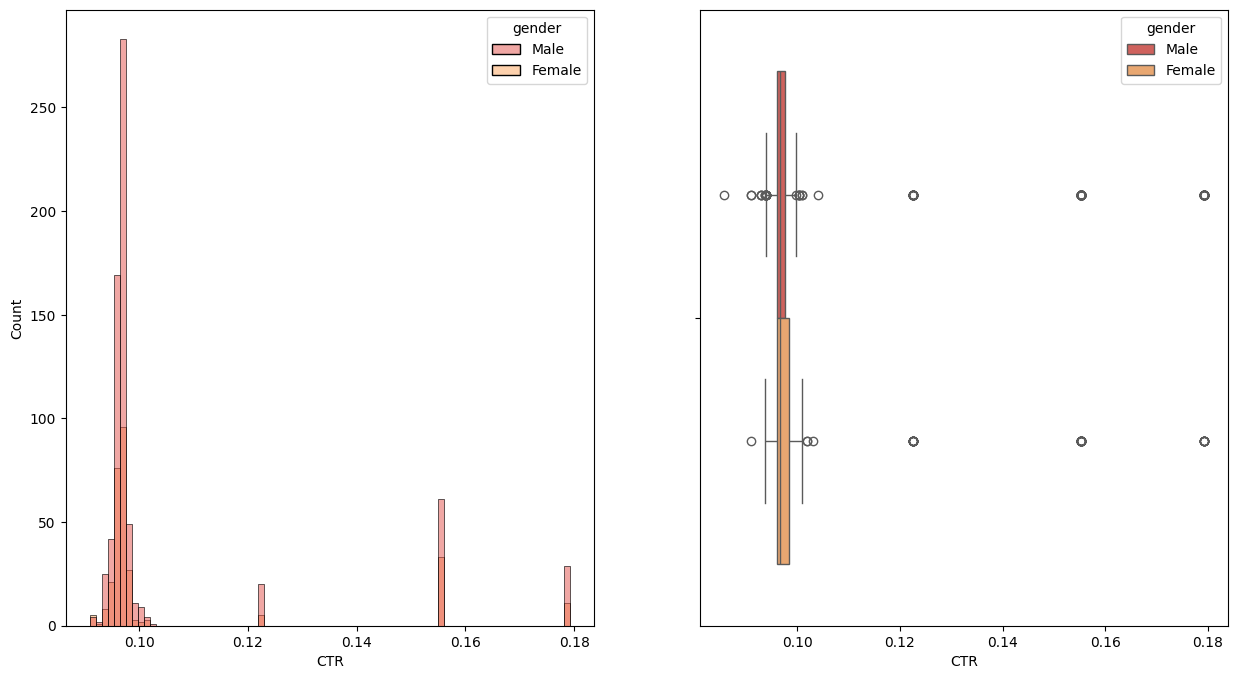

In [77]:
cat_to_q_plot(
    data=data,
    cat_col='gender',
    num_cols=['CTR'],
    shape=(1, 2)
)

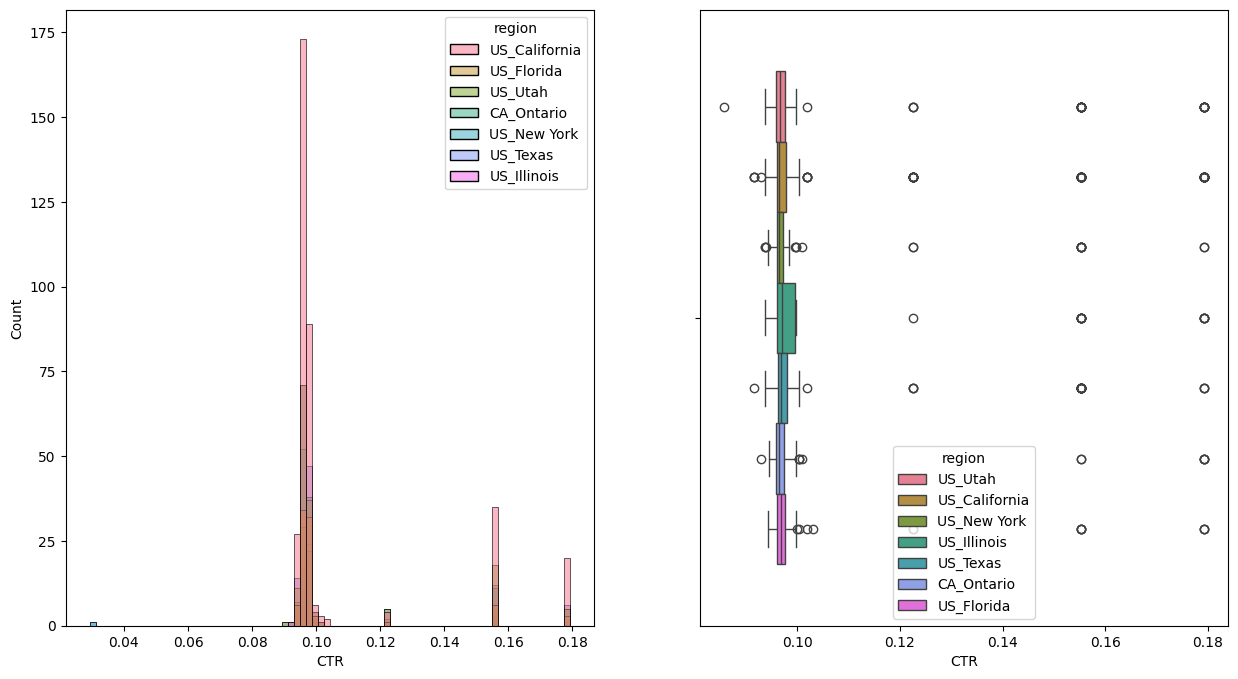

In [89]:
cat_to_q_plot(
    data=data[data.region.isin(data.region.value_counts().sort_values(ascending=False).head(7).index)],
    cat_col='region',
    num_cols=['CTR'],
    shape=(1, 2)
)

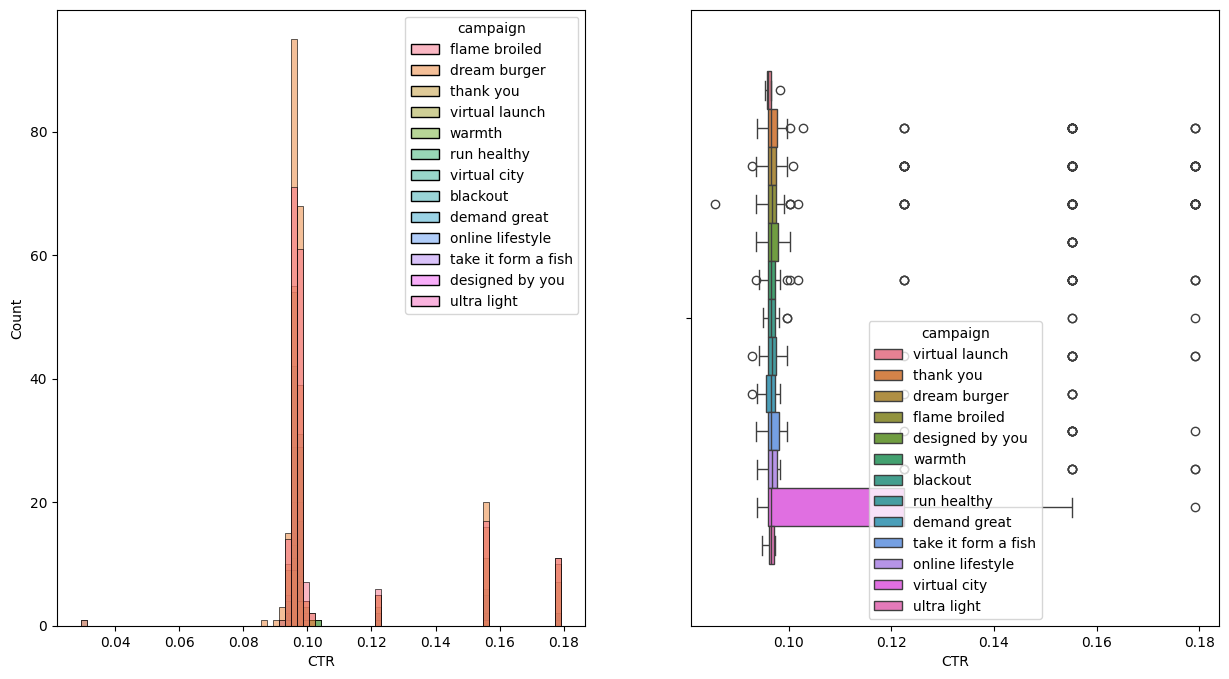

In [90]:
cat_to_q_plot(
    data=data,
    cat_col='campaign',
    num_cols=['CTR'],
    shape=(1, 2)
)

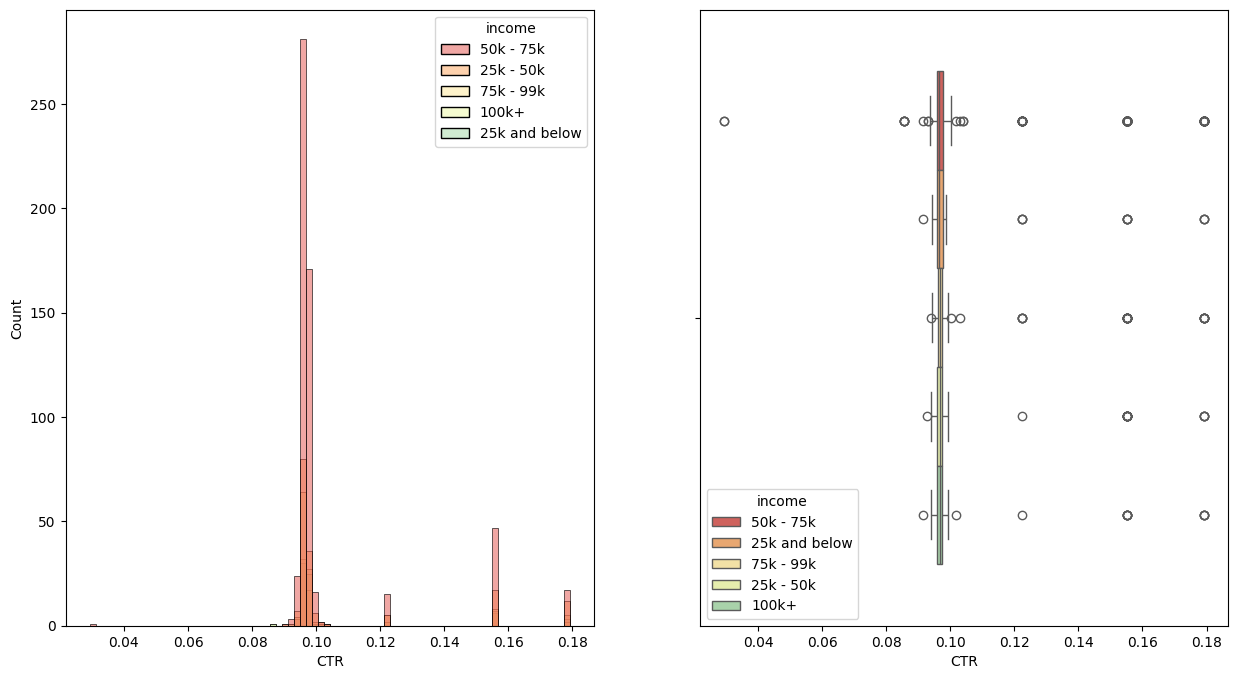

In [100]:
cat_to_q_plot(
    data=data,
    cat_col='income',
    num_cols=['CTR'],
    shape=(1, 2)
)

Conclusions:
1. For the gender and region we do not have any significant differences within the CTR, but for campaign type and income it is not that obvious.

So, let's also provide a t-test to see whether there is some significant differences between the distributions or not.

In [95]:
from scipy.stats import f_oneway

groups = [data[data['campaign'] == campaign]['CTR'] for campaign in data['campaign'].unique()]

In [97]:
f_stats, p_value = f_oneway(*groups)

if p_value >= 0.05:
    print(f"The p-value is {p_value}, we can't reject the H0. The groups' means do not differ significalntly")
else:
    print(f"The p-value is {p_value}, we can reject the H0. The groups' means differ significalntly")

The p-value is 0.24811978884817032, we can't reject the H0. The groups' means do not differ significalntly


And let's check the income as well

In [99]:
groups = [data[data['income'] == income]['CTR'] for income in data['income'].unique()]
f_stats, p_value = f_oneway(*groups)

if p_value >= 0.05:
    print(f"The p-value is {p_value}, we can't reject the H0. The groups' means do not differ significalntly")
else:
    print(f"The p-value is {p_value}, we can reject the H0. The groups' means differ significalntly")

The p-value is 0.006514990945037813, we can reject the H0. The groups' means differ significalntly


### General EDA conclusions:
1. In general dataset consists of categorical features and some of them have a big amount of unique values such as region, country, advertiser and campaign.
2. Basically all of the events were obtained in USA and Canada. By dividing this contries by states and provinces we figured out that the highest convertion rates were observed in California, Texas, New York, Utah, Florida and Ontario.
3. We can see, that men are more interested in clicking and further convertions than female. Also the same can be said for the people with median salary (up to 50k).
4. Speaking about ad campaings we can see, that the peoples' salaries are normally (almost equally) distributed within them and the ratio of impressions/clicks/convertions is also equal. After providing the additional ANOVA test we can conclude that this feature is not that relevant if we want to predict the CTR or some kind of "is_click" variable (Chi2 test also confirmed it).
5. By plotting the other categorical features with respect to the CTR we saw that non of them is that clearly separable with the event feature, but providing the Chi2 and ANOVA tests showed that there is still some significant information that these features gain about the target, which means they can used in further model training.